In [1]:
import pandas as pd 
import os

detail_result_path = '/Users/pengzhizhang/Documents/test_data/neuro/velocity_result'
output_path = detail_result_path
output_name = 'pseudo_time_neuro_combined.csv'
cell_data = pd.read_csv(os.path.join(output_path, output_name))

sub_data = cell_data[cell_data['sample']]

sub_data = sub_data.sort_values(by = ['pseudotime', 'traj_cluster'], ascending = [True, True])


In [2]:
cross = [[0, 1], [0, 3], [0, 4], [0, 5], [2, 0]]

In [207]:
import networkx as nx
import numpy as np

clusters = sub_data['traj_cluster'].drop_duplicates().to_numpy()
mytree = nx.DiGraph()

for k in clusters:
    b0 = sub_data[sub_data['traj_cluster']==k]['pseudotime'].to_numpy()

    n_node = len(b0)
    print("cluster ", k, " has ", n_node, " nodes")
    
#    if n_node < skip:
#        pass
    
    i = 0
    SCALE = 1
    skip = 10
    mytree.add_node('b'+str(k)+'_'+str(0), branch='start')
    mytree.add_node('b'+str(k)+'_'+str(n_node-1), branch='end')

    for i in range(skip, n_node, skip):
        mytree.add_node('b'+str(k)+'_'+str(i), branch='trunk')
        mytree.add_edge('b'+str(k)+'_'+str(i-skip), 'b'+str(k)+'_'+str(i), weight=SCALE*(b0[i]-b0[i-skip]))

    mytree.add_edge('b'+str(k)+'_'+str(i), 'b'+str(k)+'_'+str(n_node-1), weight=SCALE*(b0[n_node-1]-b0[i]))

#    for j in range(skip, n_node, skip):
#        mytree.add_node('b'+str(k)+'_'+str(j+n_node), branch='branch')
#        mytree.add_edge('b'+str(k)+'_'+str(j+n_node), 'b'+str(k)+'_'+str(j), weight=10)

cluster  0  has  357  nodes
cluster  2  has  146  nodes
cluster  1  has  252  nodes
cluster  4  has  39  nodes
cluster  3  has  92  nodes
cluster  5  has  2  nodes


In [208]:
for i,j in cross:
# source --> destination
# i --> j
    #print(i, j)
    itime = sub_data[sub_data['traj_cluster']==i]['pseudotime']
    jtime = sub_data[sub_data['traj_cluster']==j]['pseudotime']
    i, j = (j, i) if min(jtime) < min(itime) else (i, j)
    print(i, j)
    b0 = sub_data[sub_data['traj_cluster']==i]['pseudotime'].to_numpy()

    i_node_time = sorted([b0[int(node[3:])-1] for node, br in mytree.nodes(data=True) 
                          if ('b'+str(i)+'_' in node and br['branch'] == 'trunk')])
    
    i_node = sorted([node for node, br in mytree.nodes(data=True) 
        if ('b'+str(i)+'_' in node and br['branch'] == 'trunk')], 
       key=lambda x: int(x.split('_')[1]))
    
    ij_insect = np.searchsorted(i_node_time, min(jtime))
    #print(ij_insect, i_node, i_node_time)
    mytree.add_edge(i_node[ij_insect], 'b'+str(j)+'_'+str(0), weight=0)

0 1
0 3
0 4
0 5
0 2


{'b4_38': 'b4', 'b1_251': 'b1', 'b5_1': 'b5', 'b0_356': 'b0', 'b2_145': 'b2', 'b3_91': 'b3'}


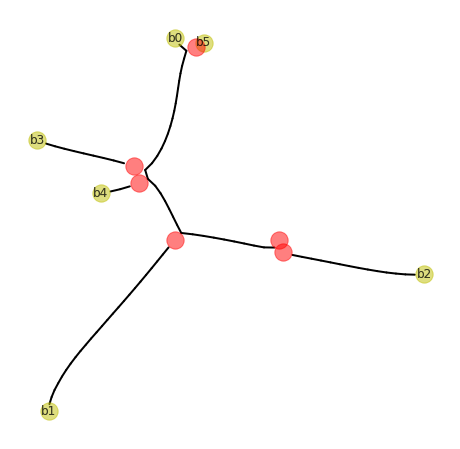

In [209]:
import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(8,8))
positions = nx.nx_pydot.graphviz_layout(mytree, prog="neato")


# trunk 
trunk_nodes = [x for x,y in mytree.nodes(data=True) if 'branch' in y and y['branch']== 'trunk']
S1 = nx.subgraph(mytree, trunk_nodes)
nx.draw(S1, pos=positions, with_labels=False, node_size=0, arrowstyle='-', alpha=1, width=2)

#nx.draw_networkx_nodes(S1, positions, node_color="b", alpha=0.5)
#nx.draw_networkx_edges(S1, positions, edge_color="k", alpha=1, arrowstyle='-', arrowsize=10)

# branch
branch_nodes = [x for x,y in mytree.nodes(data=True) if 'branch' in y and y['branch']== 'branch']
S2 = nx.subgraph(mytree, branch_nodes)
nx.draw(S2, positions, with_labels=False, node_color='b', node_size=30, alpha=0.5)
#nx.draw(S2, positions, node_color='b', alpha=0.5)


# ends
end_nodes = [x for x,y in mytree.nodes(data=True) if 'branch' in y and y['branch']== 'end']
E = nx.subgraph(mytree, end_nodes)

# starts
start_nodes = [x for x,y in mytree.nodes(data=True) if 'branch' in y and y['branch']== 'start']
S = nx.subgraph(mytree, start_nodes)



labeldict = {}
for l in E.nodes:
    labeldict[l] = l.split('_')[0]

print(labeldict)
nx.draw_networkx(E, positions, labels=labeldict, with_labels = True, node_color='y', alpha=0.5)
nx.draw_networkx(S, positions, labels=labeldict, with_labels = True, node_color='r', alpha=0.5)

plt.axis('off')
plt.show()

#nx.draw(mytree, pos=position, with_labels=True, node_size=0, arrowstyle='-')

In [ ]:
coord = np.array(list(positions.values()))
plt.scatter(coord[:,0], coord[:,1])

In [ ]:
from scipy import interpolate
help(interpolate.interp1d)
f = interpolate.interp1d(coord[:,0], coord[:,1])

plt.scatter(f[:,0], f[:,1])

In [ ]:
nx.write_gexf(mytree, "neuro.gexf")

In [ ]:
def plot_tree(G):
    from fa2 import ForceAtlas2
    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=200.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=False)

    random.seed(10)
    fig, ax = plt.subplots(figsize=(8,8))
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=10000)

    # trunk 
    trunk_nodes = [x for x,y in G.nodes(data=True) if 'branch' in y and y['branch']== 'trunk']
    S1 = nx.subgraph(G, trunk_nodes)
    nx.draw(S1, pos=positions, with_labels=True, node_size=0, arrowstyle='-', alpha=1, width=2)

    #nx.draw_networkx_nodes(S1, positions, node_color="b", alpha=0.5)
    #nx.draw_networkx_edges(S1, positions, edge_color="k", alpha=1, arrowstyle='-', arrowsize=10)

    # branch
    branch_nodes = [x for x,y in G.nodes(data=True) if 'branch' in y and y['branch']== 'branch']
    S2 = nx.subgraph(G, branch_nodes)
    nx.draw(S2, positions, with_labels=True, node_color='b', node_size=30, alpha=0.5)
    #nx.draw(S2, positions, node_color='b', alpha=0.5)


    # ends
    end_nodes = [x for x,y in G.nodes(data=True) if 'branch' in y and y['branch']== 'end']
    E = nx.subgraph(G, end_nodes)
    nx.draw_networkx_edges(E, positions, edge_color="k", alpha=1, arrowstyle='->', arrowsize=20)

    plt.axis('off')
    plt.show()


In [6]:
import igraph
print(igraph.__version__)

0.9.9


In [210]:
h = igraph.Graph.from_networkx(mytree)

(-623.3906722373581, -44.682963476863705, 192.7733342435927, 715.0712054431398)

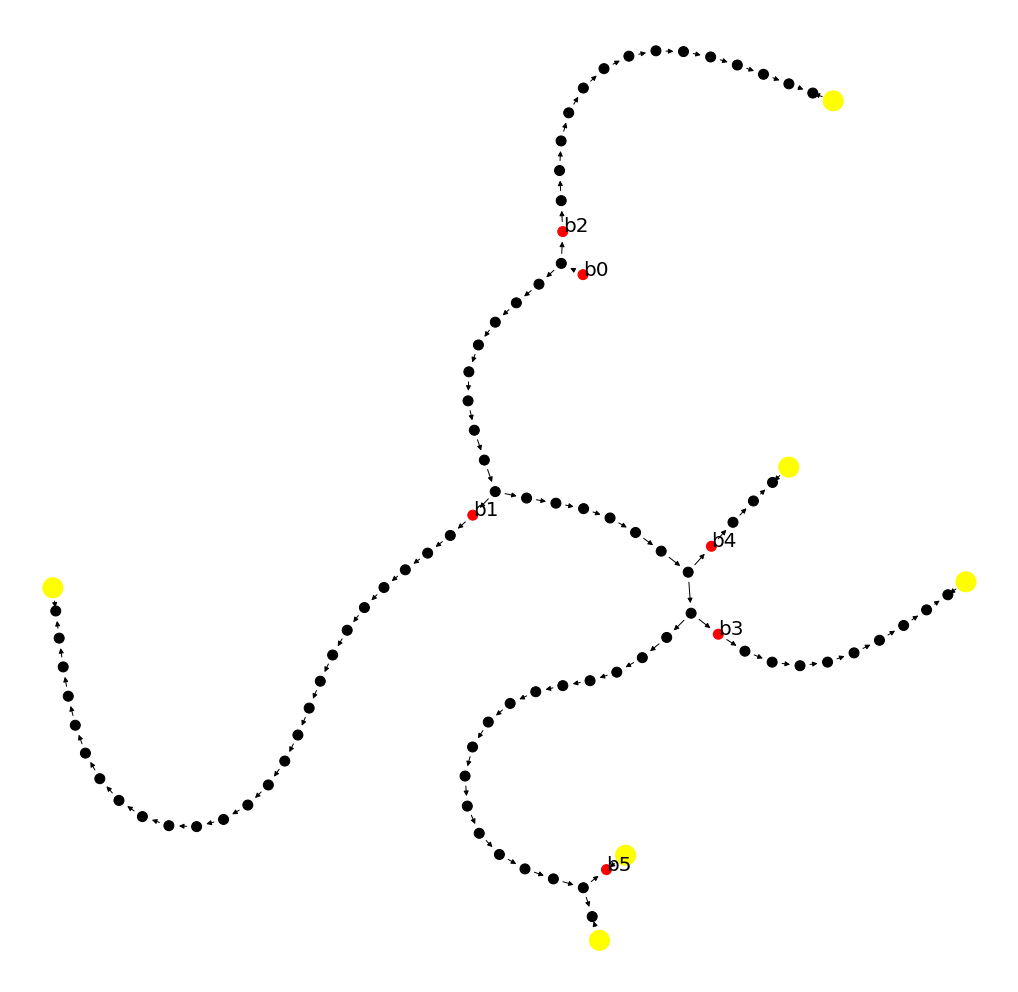

In [230]:
layout = h.layout_lgl(maxiter=10000, cellsize=100, repulserad=-1)

coord = np.array(layout.coords)
color_dict = {'start':'red', 'end':'yellow', 'trunk':'black', 'branch':'blue'}
node_size_dict = {'start':10, 'end':20, 'trunk':10, 'branch':5}


label = list()
for nd in h.vs:
    if nd['branch'] == 'start':
        label.append(nd['_nx_name'].split('_')[0])
    else:
        label.append('')

fig, ax = plt.subplots(figsize=(18,18))


visual_style = {}
visual_style["vertex_size"] = [node_size_dict[branch] for branch in h.vs["branch"]]
visual_style["vertex_color"] = [color_dict[branch] for branch in h.vs["branch"]]
visual_style["vertex_label"] = label
visual_style["vertex_label_dist"] = 20
visual_style["vertex_label_size"] = 20
visual_style["vertex_order"] = 1



#visual_style["edge_width"] = [1 + 2 * int(is_formal) for is_formal in h.es["weight"]]
visual_style["layout"] = layout
visual_style["bbox"] = (300, 300)
visual_style["margin"] = 20
igraph.plot(h, **visual_style, target=ax)



plt.axis('off')

(-3.7875, 1.1625, -1.85, 38.85)

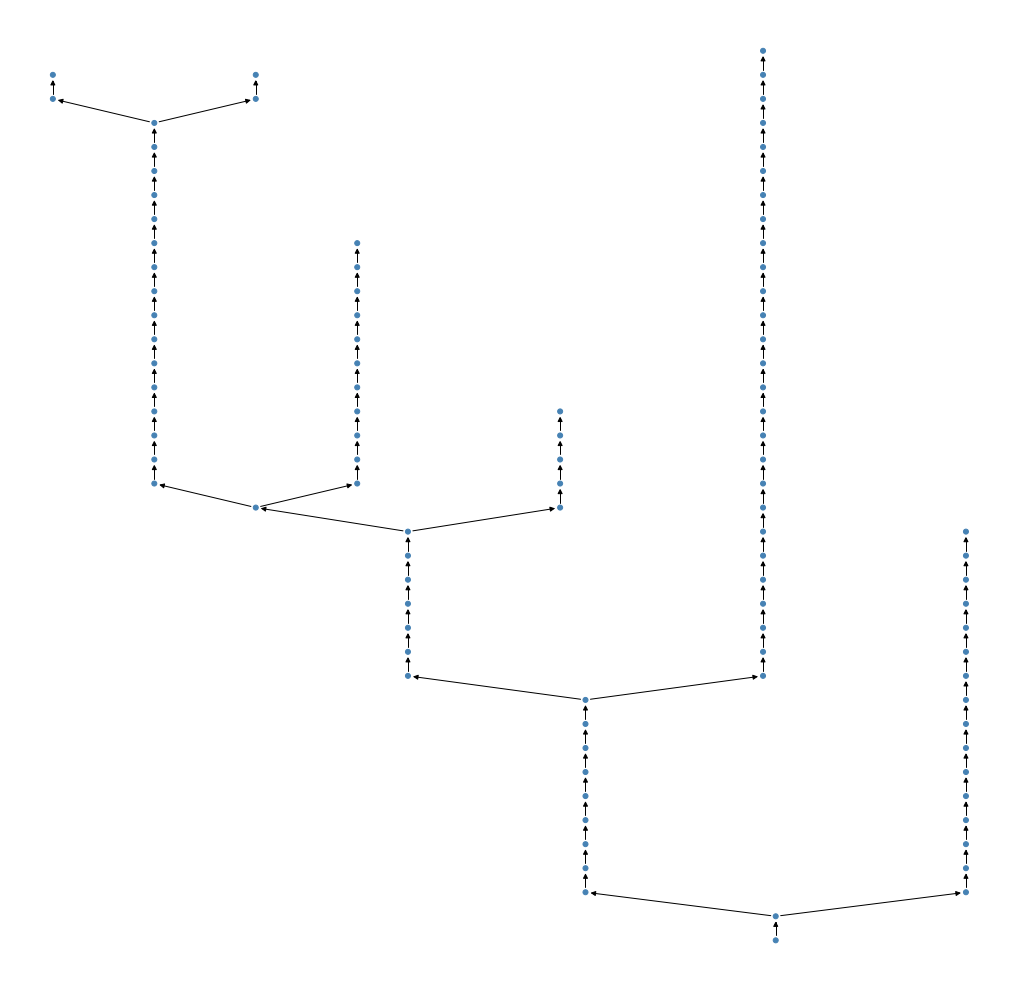

In [213]:
layout = h.layout_reingold_tilford(mode='all',root=[0])

coord = np.array(layout.coords)
fig, ax = plt.subplots(figsize=(18,18))
igraph.plot(h, layout=layout, target=ax, edge_curved=[False]*len(h.es()))
plt.axis('off')

(-3.7875, 1.1625, -1.85, 38.85)

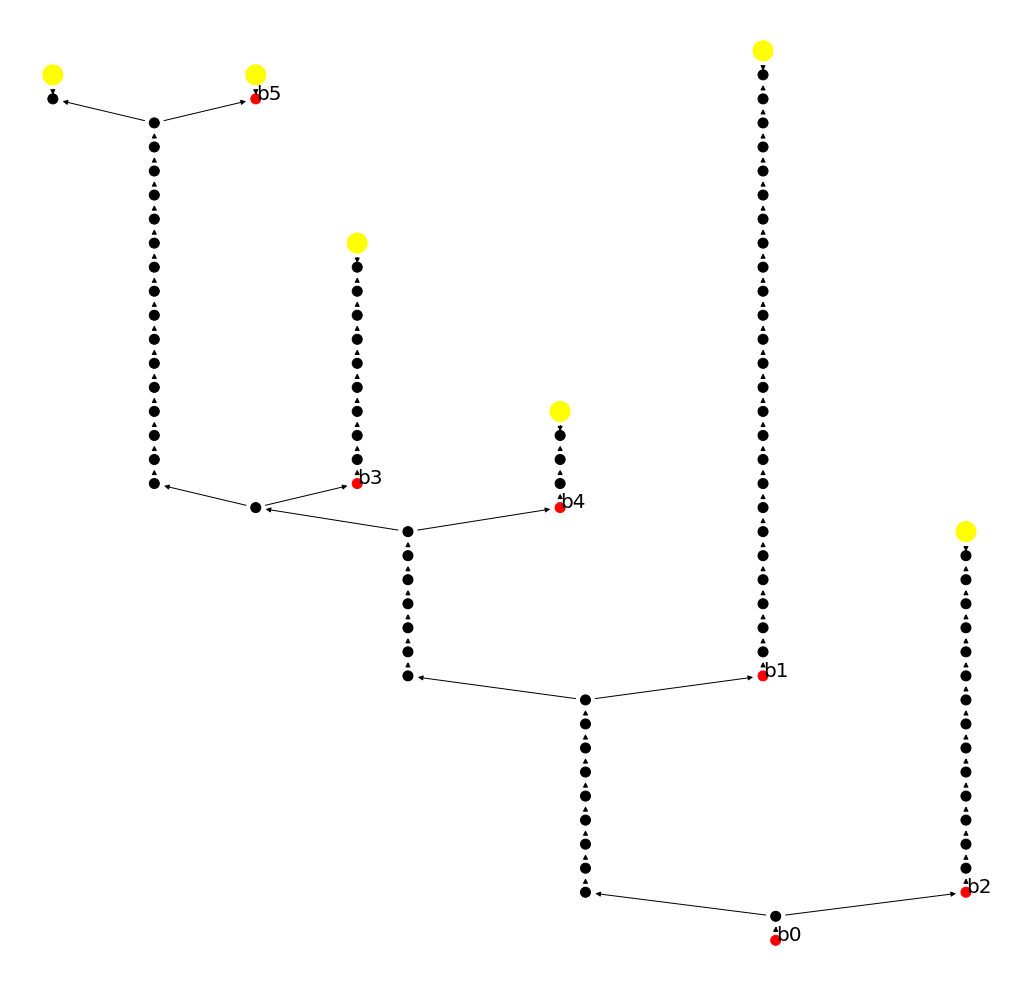

In [214]:
color_dict = {'start':'red', 'end':'yellow', 'trunk':'black', 'branch':'blue'}
node_size_dict = {'start':10, 'end':20, 'trunk':10, 'branch':5}


label = list()
for nd in h.vs:
    if nd['branch'] == 'start':
        label.append(nd['_nx_name'].split('_')[0])
    else:
        label.append('')

fig, ax = plt.subplots(figsize=(18,18))


visual_style = {}
visual_style["vertex_size"] = [node_size_dict[branch] for branch in h.vs["branch"]]
visual_style["vertex_color"] = [color_dict[branch] for branch in h.vs["branch"]]
visual_style["vertex_label"] = label
visual_style["vertex_label_dist"] = 20
visual_style["vertex_label_size"] = 20
visual_style["vertex_order"] = 1



#visual_style["edge_width"] = [1 + 2 * int(is_formal) for is_formal in h.es["weight"]]
visual_style["layout"] = layout
visual_style["bbox"] = (300, 300)
visual_style["margin"] = 20
igraph.plot(h, **visual_style, target=ax)



plt.axis('off')